# Installing libraries

In [ ]:
!pip install -U pynwb --quiet
!pip install wget --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.0/134.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.0/332.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Imports

In [ ]:
import wget
import zipfile
import os
import numpy as np

# Download and unpack data

In [ ]:
wget.download("https://osf.io/download/g6q5m/", "SingleWordProductionDutch-iBIDS.zip")

'SingleWordProductionDutch-iBIDS.zip'

In [ ]:
with zipfile.ZipFile('SingleWordProductionDutch-iBIDS.zip', 'r') as zip_ref:
    zip_ref.extractall()
os.remove('SingleWordProductionDutch-iBIDS.zip')

# Processing data

In [ ]:
!wget https://raw.githubusercontent.com/eva-vision/2BRAINS/main/MelFilterBank.py --quiet
!wget https://raw.githubusercontent.com/eva-vision/2BRAINS/main/extract_features.py --quiet
!wget https://raw.githubusercontent.com/neuralinterfacinglab/SingleWordProductionDutch/main/reconstructWave.py --quiet

In [ ]:
!python MelFilterBank.py
!python reconstructWave.py
!python extract_features.py

Traceback (most recent call last):
  File "/content/reconstructWave.py", line 55, in <module>
    (sr,wf) = wavefile.read('something.wav')
  File "/usr/local/lib/python3.10/dist-packages/scipy/io/wavfile.py", line 647, in read
    fid = open(filename, 'rb')
FileNotFoundError: [Errno 2] No such file or directory: 'something.wav'
Traceback (most recent call last):
  File "/content/extract_features.py", line 198, in <module>
    feat = stackFeatures(feat,modelOrder=modelOrder,stepSize=stepSize)
  File "/content/extract_features.py", line 79, in stackFeatures
    featStacked[fNum,:]=ef.flatten() #Add 'F' if stacked the same as matlab
KeyboardInterrupt
^C


In [ ]:
import scipy.io.wavfile as wavfile
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import reconstructWave as rW
import MelFilterBank as mel

In [ ]:
def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
    """
    Create a reconstructed audio wavefrom

    Parameters
    ----------
    spectrogram: array
        Spectrogram of the audio
    sr: int
        Sampling rate of the audio
    windowLength: float
        Length of window (in seconds) in which spectrogram was calculated
    frameshift: float
        Shift (in seconds) after which next window was extracted
    Returns
    ----------
    scaled: array
        Scaled audio waveform
    """
    mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
    nfolds = 10
    hop = int(spectrogram.shape[0]/nfolds)
    rec_audio = np.array([])
    for_reconstruction = mfb.fromLogMels(spectrogram)
    for w in range(0,spectrogram.shape[0],hop):
        spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
        rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
        rec_audio = np.append(rec_audio,rec)
    scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
    return scaled

In [ ]:
feat_path = r'./features'
result_path = r'./results'
pts = ['sub-%02d'%i for i in range(1,11)]

pt = 'sub-06'
pNr = 5

winLength = 0.05
frameshift = 0.01
audiosr = 16000

nfolds = 10
kf = KFold(nfolds,shuffle=False)
est = LinearRegression(n_jobs=5)
pca = PCA()
numComps = 50

#Initialize empty matrices for correlation results, randomized contols and amount of explained variance
allRes = np.zeros((len(pts),nfolds,23))
explainedVariance = np.zeros((len(pts),nfolds))
numRands = 1000
randomControl = np.zeros((len(pts),numRands, 23))

#Load the data
spectrogram = np.load(os.path.join(feat_path,f'{pt}_spec.npy'))
data = np.load(os.path.join(feat_path,f'{pt}_feat.npy'))
featName = np.load(os.path.join(feat_path,f'{pt}_feat_names.npy'))

#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))

#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
    #Z-Normalize with mean and std from the training data
    mu=np.mean(data[train,:],axis=0)
    std=np.std(data[train,:],axis=0)
    trainData=(data[train,:]-mu)/std
    testData=(data[test,:]-mu)/std

    #Fit PCA to training data
    pca.fit(trainData)
    #Get percentage of explained variance by selected components
    explainedVariance[pNr,k] =  np.sum(pca.explained_variance_ratio_[:numComps])
    #Tranform data into component space
    trainData=np.dot(trainData, pca.components_[:numComps,:].T)
    testData = np.dot(testData, pca.components_[:numComps,:].T)

    #Fit the regression model
    est.fit(trainData, spectrogram[train, :])
    #Predict the reconstructed spectrogram for the test data
    rec_spec[test, :] = est.predict(testData)

    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
        if np.any(np.isnan(rec_spec)):
            print('%s has %d broken samples in reconstruction' % (pt, np.sum(np.isnan(rec_spec))))
    r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
    rs[k,specBin] = r

#Show evaluation result
print('%s has mean correlation of %f' % (pt, np.mean(rs)))
allRes[pNr,:,:]=rs

#Estimate random baseline
for randRound in range(numRands):
    #Choose a random splitting point at least 10% of the dataset size away
    splitPoint = np.random.choice(np.arange(int(spectrogram.shape[0]*0.1),int(spectrogram.shape[0]*0.9)))
    #Swap the dataset on the splitting point
    shuffled = np.concatenate((spectrogram[splitPoint:,:],spectrogram[:splitPoint,:]))
    #Calculate the correlations
    for specBin in range(spectrogram.shape[1]):
        if np.any(np.isnan(rec_spec)):
            print('%s has %d broken samples in reconstruction' % (pt, np.sum(np.isnan(rec_spec))))
        r, p = pearsonr(spectrogram[:,specBin], shuffled[:,specBin])
        randomControl[pNr, randRound,specBin]=r


#Save reconstructed spectrogram
os.makedirs(os.path.join(result_path), exist_ok=True)
np.save(os.path.join(result_path,f'{pt}_predicted_spec.npy'), rec_spec)

#Synthesize waveform from spectrogram using Griffin-Lim
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join(result_path,f'{pt}_predicted.wav'),int(audiosr),reconstructedWav)

#For comparison synthesize the original spectrogram with Griffin-Lim
origWav = createAudio(spectrogram,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join(result_path,f'{pt}_orig_synthesized.wav'),int(audiosr),origWav)

#Save results in numpy arrays
np.save(os.path.join(result_path,'linearResults.npy'),allRes)
np.save(os.path.join(result_path,'randomResults.npy'),randomControl)
np.save(os.path.join(result_path,'explainedVariance.npy'),explainedVariance)

sub-06 has mean correlation of 0.033420


In [ ]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

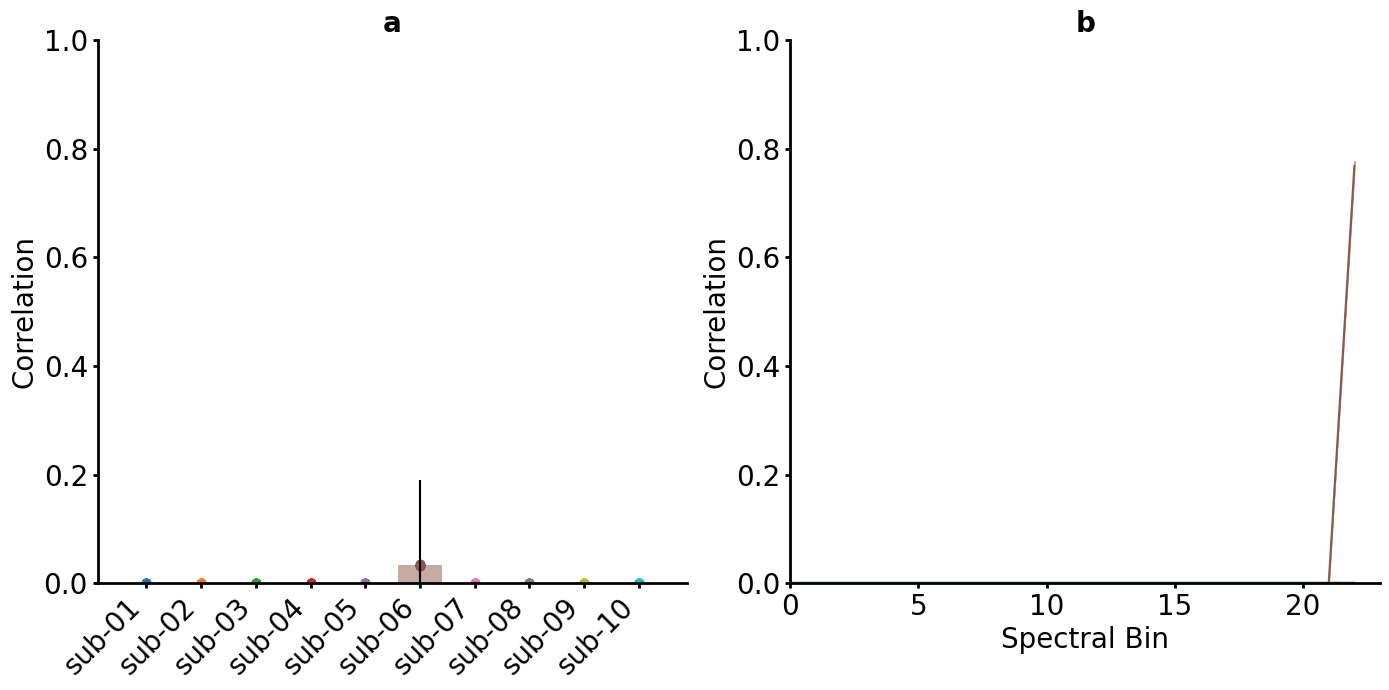

NameError: ignored

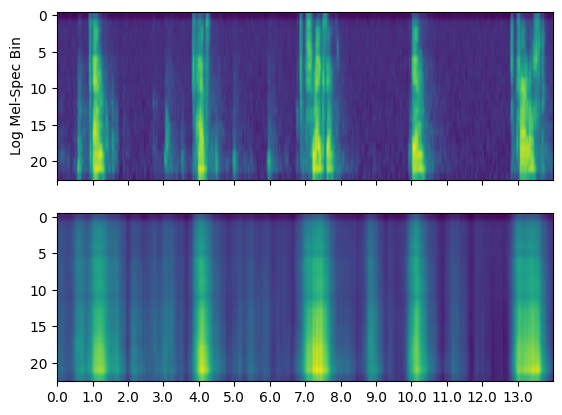

In [ ]:
    result_path = r'./results'
    #Load correlation results
    allRes = np.load(os.path.join(result_path,'linearResults.npy'))

    colors = ['C' + str(i) for i in range(10)]

    meanCorrs = np.mean(allRes,axis=(1,2))
    stdCorrs = np.std(allRes, axis=(1,2))

    x = range(len(meanCorrs))
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    #Barplot of average results
    ax[0].bar(x,meanCorrs,yerr=stdCorrs,alpha=0.5,color=colors)
    for p in range(allRes.shape[0]):
        #Add mean results of each patient as scatter points
        ax[0].scatter(np.zeros(allRes[p,:,:].shape[0])+p,np.mean(allRes[p,:,:],axis=1),color=colors[p])

    ax[0].set_xticks(x)
    ax[0].set_xticklabels(['sub-' + "{:02d}".format(i+1) for i in x],rotation=45, ha='right',fontsize=20)
    ax[0].set_ylim(0,1)
    ax[0].set_ylabel('Correlation')
    #Title
    ax[0].set_title('a',fontsize=20,fontweight="bold")
    # Make pretty
    plt.setp(ax[0].spines.values(), linewidth=2)
    #The ticks
    ax[0].xaxis.set_tick_params(width=2)
    ax[0].yaxis.set_tick_params(width=2)
    ax[0].xaxis.label.set_fontsize(20)
    ax[0].yaxis.label.set_fontsize(20)
    c = [a.set_fontsize(20) for a in ax[0].get_yticklabels()]

    #Despine
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)

    #Mean across folds over spectral bins
    specMean = np.mean(allRes,axis=1)
    specStd = np.std(allRes,axis=1)
    specBins = np.arange(allRes.shape[2])
    for p in range(allRes.shape[0]):
        ax[1].plot(specBins, specMean[p,:],color=colors[p])
        error = specStd[p,:]/np.sqrt(allRes.shape[1])
        #Shaded areas highlight standard error
        ax[1].fill_between(specBins,specMean[p,:]-error,specMean[p,:]+error,alpha=0.5,color=colors[p])
    ax[1].set_ylim(0,1)
    ax[1].set_xlim(0,len(specBins))
    ax[1].set_xlabel('Spectral Bin')
    ax[1].set_ylabel('Correlation')
    #Title
    ax[1].set_title('b',fontsize=20,fontweight="bold")

    #Make pretty
    plt.setp(ax[1].spines.values(), linewidth=2)
    #The ticks
    ax[1].xaxis.set_tick_params(width=2)
    ax[1].yaxis.set_tick_params(width=2)
    ax[1].xaxis.label.set_fontsize(20)
    ax[1].yaxis.label.set_fontsize(20)
    c = [a.set_fontsize(20) for a in ax[1].get_yticklabels()]
    c = [a.set_fontsize(20) for a in ax[1].get_xticklabels()]
    #Despine
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(os.path.join(result_path,'results.png'),dpi=600)
    plt.show()

    # Viz example spectrogram
    #Load words and spectrograms
    feat_path = r'./features'
    participant = 'sub-06'
    #Which timeframe to plot
    start_s = 5.5
    stop_s=19.5

    frameshift = 0.01
    #Load spectrograms
    rec_spec = np.load(os.path.join(result_path, f'{participant}_predicted_spec.npy'))
    spectrogram = np.load(os.path.join(feat_path, f'{participant}_spec.npy'))
    #Load prompted words
    eeg_sr= 1024
    #words = np.load(os.path.join(feat_path,f'{participant}_procWords.npy'))[int(start_s*eeg_sr):int(stop_s*eeg_sr)]
    #words = [words[w] for w in np.arange(1,len(words)) if words[w]!=words[w-1] and words[w]!='']

    cm='viridis'
    fig, ax = plt.subplots(2, sharex=True)
    #Plot spectrograms
    pSta=int(start_s*(1/frameshift));pSto=int(stop_s*(1/frameshift))
    ax[0].imshow(np.flipud(spectrogram[pSta:pSto, :].T), cmap=cm, interpolation=None,aspect='auto')
    ax[0].set_ylabel('Log Mel-Spec Bin')
    ax[1].imshow(np.flipud(rec_spec[pSta:pSto, :].T), cmap=cm, interpolation=None,aspect='auto')
    plt.setp(ax[1], xticks=np.arange(0,pSto-pSta,int(1/frameshift)), xticklabels=[str(x/int(1/frameshift)) for x in np.arange(0,pSto-pSta,int(1/frameshift))])
    plt.setp(ax[1], xticks=np.arange(int(1/frameshift),spectrogram[pSta:pSto, :].shape[0],3*int(1/frameshift)), xticklabels=words)
    ax[1].set_ylabel('Log Mel-Spec Bin')

    plt.savefig(os.path.join(result_path,'spec_example.png'),dpi=600)

    #Saving for use in Adobe Illustrator
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.savefig(os.path.join(result_path,'spec_example.pdf'),transparent=True)
    plt.show()


    # Viz waveforms
    #Load waveforms
    rate, audio = wavfile.read(os.path.join(result_path,f'{participant}_orig_synthesized.wav'))
    rate, recAudio = wavfile.read(os.path.join(result_path,f'{participant}_predicted.wav'))

    orig = audio[int(start_s*rate):int(stop_s*rate)]
    rec = recAudio[int(start_s*rate):int(stop_s*rate)]
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(orig)
    axarr[1].plot(rec)

    #Axis
    xts = np.arange(rate,orig.shape[0]+1,3*rate)
    axarr[1].set_xticks(xts)
    axarr[1].set_xticklabels(words)
    axarr[0].set_xlim([0,orig.shape[0]])
    axarr[0].set_ylim([-np.max(np.abs(orig)),np.max(np.abs(orig))])
    axarr[1].set_ylim([-np.max(np.abs(rec)),np.max(np.abs(rec))])

    #Add line indicating 3 seconds
    axarr[1].annotate("",xy=(xts[0], 27000), xycoords='data',xytext=(xts[1],27000), textcoords='data',
                arrowprops=dict(arrowstyle="-",
                                connectionstyle="arc3"),
                )
    axarr[1].annotate("3 seconds",xy=((xts[0]+xts[1])/2, 22000), horizontalalignment='center')

    #Axis labels
    axarr[0].set_ylabel('Original')
    axarr[0].set_yticks([])
    axarr[1].set_yticks([])
    axarr[1].set_ylabel('Amplitude')
    axarr[0].set_ylabel('Amplitude')
    axarr[1].text(orig.shape[0],0,'Reconstruction',horizontalalignment='left',verticalalignment='center',rotation='vertical',)
    axarr[0].text(orig.shape[0],0,'Original',horizontalalignment='left',verticalalignment='center',rotation='vertical',)

    #Make Pretty
    ax[1].xaxis.set_tick_params(width=2)
    ax[1].yaxis.set_tick_params(width=2)
    ax[1].xaxis.label.set_fontsize(20)
    ax[1].yaxis.label.set_fontsize(20)
    c = [a.set_fontsize(20) for a in ax[1].get_yticklabels()]
    c = [a.set_fontsize(20) for a in ax[1].get_xticklabels()]
    #ax.get_yticklabels().set_fontsize(28)

    #Despine
    for axes in axarr:
        axes.spines['right'].set_visible(False)
        axes.spines['top'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        #axes.spines['top'].set_visible(False)

    plt.savefig(os.path.join(result_path,'wav_example.png'),dpi=600)
    #Saving for usage in Adobe Illustrator
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.savefig(os.path.join(result_path,'wav_example.pdf'),transparent = True)
    plt.show()